In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeled_train_clean_reviews.csv'
TEST_DF = BASE_DIR + 'test_clean_reviews.csv'

In [2]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0)
test = pd.read_csv(TEST_DF, header = 0)
labeled_train["review"] = labeled_train["review"].astype(str)
test["review"] = test["review"].astype(str)
print "Read %d labeled train reviews" \
          "and %d test reviews" % (labeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviewsand 25000 test reviews


Data leakage

Check if test["sentiment"] is correct

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [4]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 300  # Word vector dimensionality
MIN_WORD_COUNT = 40  # Minimum word count. Kaggle set to 40, to avoid attaching too much importance to individual movie titles.
NUM_THREADS = 4  # Number of threads to run in parallel
CONTEXT = 10  # Context window size
DOWNSAMPLING = 1e-3  # Downsample setting for frequent words
WORD2VEC_MODEL_FILE = BASE_DIR + \
    "word2vec_model_" + \
    str(EMBEDDING_DIM) + "dim_" + \
    str(MIN_WORD_COUNT) + "minwords_" + \
    str(CONTEXT) + "context"

word2vec_model = Word2Vec.load(WORD2VEC_MODEL_FILE)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

print("Number of words in the word2vec model vocabulary: %d" % len(word2vec_model.wv.vocab))

Number of words in the word2vec model vocabulary: 16490


Prepare

In [5]:
train_clean_reviews = labeled_train["review"].tolist()
test_clean_reviews = test["review"].tolist()

all_clean_reviews = train_clean_reviews + test_clean_reviews

In [6]:
print(np.random.choice(all_clean_reviews, 1))

['at a time in our culture where reality exposed as narrative is overpowering fiction as we know it on the small and big screen    apart from that   is a film that exposes real life moments that feel more honest  fresh and innovative in there presentation than i have ever seen before  the usual spoon feeding conventions are non existent in this film  leaving a content audience to sit and watch these real life moments trickle one after the other on the screen  while watching the movie  and even upon post contemplation  it is hard to believe that these amazing performances where actually that  performances  every moment with the large cast of actors felt like the truth being exposed in their daily usual lives  even so    apart from that   does not feel like a documentary or reality television  but instead transcends into a category of its own  with its unique cinematography and direction  i look forward to watching this new category of storytelling continue with other films by directors 

In [7]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Using TensorFlow backend.


Keras Tokenizer found 101376 unique tokens


In [8]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [9]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv.get_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 84920


In [10]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [11]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, Conv1D, MaxPooling1D ,GlobalMaxPooling1D
from keras.initializers import Constant

In [13]:
def cnn_rnn_model(dropout_cnn=0.5, dropout_rnn=0.2, num_filters=64, kernel_size=2):
    model = Sequential()
    
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.

    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=1))
    # Cannot use GlobalMaxPooling since you're feeding it into RNN
    model.add(MaxPooling1D(2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_cnn))
    model.add(Bidirectional(LSTM(LSTM_UNITS, 
                                 dropout=LSTM_DROPOUT, 
                                 recurrent_dropout=LSTM_RECCURENT_DROPOUT
                                )))
    model.add(Dropout(dropout_rnn))
    model.add(output_layer)
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [14]:
model = cnn_rnn_model()

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30413100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 64)           38464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 249, 32)           2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 249, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [16]:
# batch_size: number of samples per gradient update
history = model.fit(x_train, y_train, batch_size=64, epochs=12, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/12
20000/20000 [==============================] - 276s 14ms/step - loss: 0.4436 - acc: 0.7916 - val_loss: 0.3151 - val_acc: 0.8736
Epoch 2/12
20000/20000 [==============================] - 274s 14ms/step - loss: 0.3213 - acc: 0.8700 - val_loss: 0.2989 - val_acc: 0.8742
Epoch 3/12
20000/20000 [==============================] - 274s 14ms/step - loss: 0.2949 - acc: 0.8842 - val_loss: 0.3295 - val_acc: 0.8620
Epoch 4/12
20000/20000 [==============================] - 274s 14ms/step - loss: 0.2945 - acc: 0.8819 - val_loss: 0.2930 - val_acc: 0.8786
Epoch 5/12
20000/20000 [==============================] - 274s 14ms/step - loss: 0.2620 - acc: 0.8972 - val_loss: 0.2816 - val_acc: 0.8866
Epoch 6/12
20000/20000 [==============================] - 273s 14ms/step - loss: 0.2525 - acc: 0.9007 - val_loss: 0.2740 - val_acc: 0.8848
Epoch 7/12
20000/20000 [==============================] - 275s 14ms/step - loss: 0.2547 - acc: 0.8993 - val_loss: 0.2

In [17]:
y_test_pred = model.predict(x_test)

In [18]:
y_test_pred_binary = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred)

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [20]:
print("The AUC score for CNN-BiLSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_binary))

The AUC score for CNN-BiLSTM model is : 0.9011.


In [27]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary})
output.to_csv(os.path.join('../', 'output', "cnn_bilstm_word2vec_12epoch.csv"), index=False, quoting=3)
print "Wrote to cnn_bilstm_word2vec_12epoch.csv"

Wrote to cnn_bilstm_word2vec_12epoch.csv


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

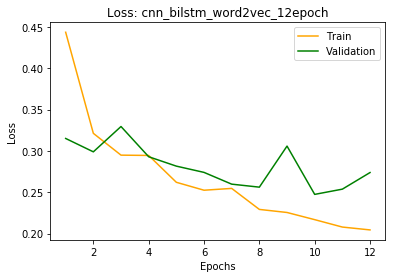

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: cnn_bilstm_word2vec_12epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/cnn_bilstm_word2vec_12epoch_loss.png', dpi=900)

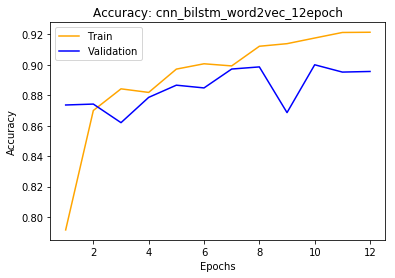

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: cnn_bilstm_word2vec_12epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/cnn_bilstm_word2vec_12epoch_accuracy.png', dpi=900)